In [1]:
%%HTML

<!-- Not content, but for better presentation styles -->
<style>
.CodeMirror {
    width: 100vw;
}

.container {
    width: 60% !important;
}

.rendered_html {
  font-size:0.8em;
}
.rendered_html table, .rendered_html th, .rendered_html tr, .rendered_html td {
     font-size: 100%;
}
.rendered_html code {
    background: #EFEFEF;
    border: 1px solid #CCC;
    padding: 1px 5px;
    border-radius: 1px;
}
.rise-enabled .fa-times-circle:before,
.rise-enabled .fa-question:before,
.rise-enabled aside.controls {
    opacity: 0.1;
}
.rise-enabled a,
.rise-enabled a:active,
.rise-enabled a:hover,
.rise-enabled a:visited,
.rise-enabled :link {
    text-decoration: none;
    color: #A68910;
}
</style>

In [2]:
from traitlets.config.manager import BaseJSONConfigManager
from pathlib import Path
path = Path.home() / ".jupyter" / "nbconfig"
cm = BaseJSONConfigManager(config_dir=str(path))
cm.update(
    "rise",
    {
        "theme": "sky",
        "transition": "zoom",
        "start_slideshow_at": "selected",
        "scroll": True
     }
)

{'theme': 'sky',
 'transition': 'zoom',
 'start_slideshow_at': 'selected',
 'scroll': True}

# Using differentiable programming to build custom machine learning algorithms
### 1. The why of differentiable programming
### 3. Comparison between pyTorch, TensorFlow and JAX
### 4. First exampe: estimating power series coefficients
### 5. GPU acceleration with XLA
### 6. The problem with clustering in high dimensions
### 7. Kmeans in JAX

In [3]:
# Import tensorflow, pytorch and jax to compare the three

import jax
import jax.numpy as np
import numpy as onp  #old numpy

import torch

import tensorflow as tf

import matplotlib.pyplot as plt

import pandas as pd

# Why differentiable programming?

Statistics is the method we have to draw conclusion with only limited information. 
**Let us apply that to computer programs!**

## What if we could write a program that can perform a certain task without knowing exactly how to do it?

1. Write the outline of a program with some or all pieces missing but parametrised.
2. Construct a function `f` telling if the program was successful or not when performing a task.
3. Differentiate `f` with respect to the missing information/parameters.
4. Give examples of successful executions of the program given some input.
5. Optimise the program using stocastic gradient descent.
6. Voila, we now have a working program that can do what we want!

# How is this different from a neural network?

In essence not at all!

## A deep neural network is an (almost) maximally parametrised computer program built to achieve a given task

It is maximally parametrised in the sense that we have given very little information on how the task is to be perfomed, 
but instead given it a lot of power (weights) to learn all steps of the program by it self.

A convolutional network has extra information since we told it to build **image kernels** to handle the input.

A (boosted) decision tree is in some sense less parametrised: it can learn faster from less data since we have given the program more structure 
(use **a lot of if clauses** to decide the output).

To achieve this goal we need one main ingredient:
    
**To be able to automatically differentiate 
arbitrary computer programs.**

In [ ]:
What is JAX SLIde. introduce XLA.

In [ ]:
def first_example(x):
    n = 1
    for a in range(3):
        n = n * x
    return n

In [ ]:
x = 2.0

first_example(x)

In [ ]:
jax.grad(first_example)(x)

In [4]:
def second_example(x):
    if x <= 3:
        return x * 2
    else:
        return x ** 2

In [ ]:
grad_second_example = jax.grad(second_example)

In [ ]:
grad_second_example

In [ ]:
grad_second_example(2.0)

In [ ]:
grad_second_example(4.0)

## Automatic differentiation works by:
1. Recording all operations done on a variable, which gives us the computation graph. The order in which 
operations were executed is recorded using a bookkeeping 
device called a (Wengert) tape (Note: this is to simplify the backwards pass...). 
Tf and JAX use tapes while pyTorch lets each variable remember its own lineage.
2. Applying the chain rule on the composition
on all _primitive_ operations in the graph.
3. Keeping a table on how to differentiate all those primitive operations.

# Why JAX and not Tensorflow and pyTorch?

Jax, tensorflow and pyTorch are all essentially differentiable programming frameworks but limited in what kind of programs they can differentiate.

In [119]:
torch.autograd.grad(y, x)

RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.

In [120]:
y

tensor(4., grad_fn=<MulBackward0>)

In [121]:
x + 1 # grad_fn remembers what operations have been performed on

tensor(3., grad_fn=<AddBackward0>)

In [122]:
x ** 2

tensor(4., grad_fn=<PowBackward0>)

In [123]:
# what happens if we use different x's??

torch.autograd.grad(torch.autograd.grad(second_example(x), x, create_graph=True), x)

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [140]:
y = second_example(x)
z = torch.autograd.grad(y, x, retain_graph=False, create_graph=True)

In [142]:
torch.__version__


'1.4.0'

# What about TensorFlow?

In [ ]:
x = tf.Variable(4.0, dtype=tf.float32)

with tf.GradientTape(persistent=True) as t:
    y = second_example(x)

t.gradient(y, x).numpy()

In [ ]:
t.gradient(t.gradient(y, x), x)

In [ ]:
x = tf.Variable(4.0, dtype=tf.float32)

with tf.GradientTape() as t:
    t.watch(x)
    with tf.GradientTape() as t2:
        y = second_example(x)
        dy = t2.gradient(y, x)

t.gradient(dy, x).numpy()

# Let us train our first program!

We trying to do some something simple, learn the coefficients of a power series.

In [115]:
from jax.experimental import optimizers
import jax.numpy as np
from jax import jit, grad, random

#
# Test to learn a power series expansion of 1 - tanh(2x)
#

def power_series_expansion(param, x, n):
    """Return the parametrised power series expansion up to the nth term"""
    return np.dot(param, np.array([x**i for i in range(n)]))


def target(x):
    """The function whose power series we want to learn"""
    return 1 - np.tanh(2.0 * x)


def loss_func(param, x, f, n):
    """Compare power series with target"""
    return (power_series_expansion(param, x, n) - f(x))**2


def fit():
    """Learn the program"""
    n = 10
    init_value = np.zeros(n)
    step_size = 0.01
    seed = 42
    iterations = 1000
    closeness_to_zero = 1.2
    opt_init, opt_update, get_params = optimizers.adam(step_size)
    opt_state = opt_init(init_value)
    key = random.PRNGKey(seed)
    fit_list = []

    @jit
    def update(i, opt_state, key):
        params = get_params(opt_state)
        x = random.randint(key, (1, ), 0, 100)[0]/(closeness_to_zero * 100)
        loss = grad(loss_func)(params, x, target, n)
        return opt_update(i, loss, opt_state)

    for i in range(iterations):
        key, key_ = random.split(key)
        opt_state = update(i, opt_state, key_)
        fit_list.append(get_params(opt_state))
    return fit_list, closeness_to_zero


res, closeness_to_zero = fit()

<IPython.core.display.Javascript object>


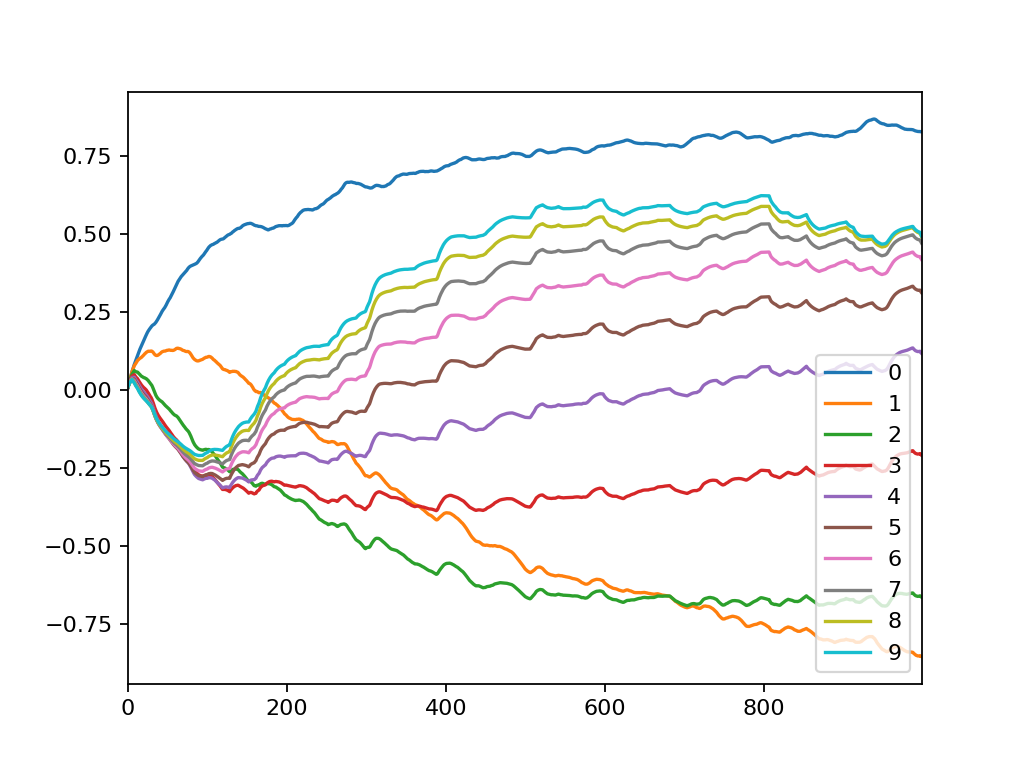

In [116]:
pd.DataFrame([a._value for a in res]).plot()

In [108]:
error = jax.vmap(
    lambda r: np.mean(jax.vmap(
        lambda x: target(x) - power_series_expansion(r, x, 10)
    )(onp.random.randint(0, 100, 100)/(closeness_to_zero * 100)))
)(np.array(res))

<IPython.core.display.Javascript object>


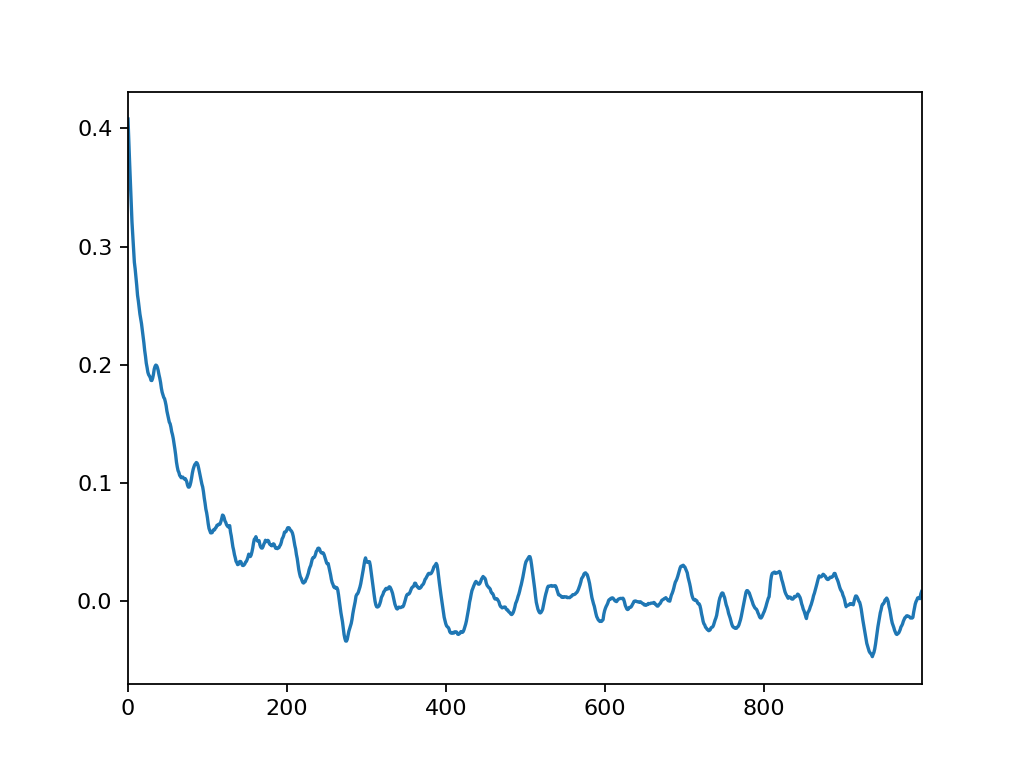

In [109]:
#error
%matplotlib notebook

pd.Series(error).plot()

In [ ]:
# Could be fun to show that Taylor solution does not converge if we are too far away from 0.

# What about GPUs?

![XLA](xla2.png "XLA")



![XLA](xla1.png "XLA")

Can be used in JAX, pyTorch and TensorFlow.

Can optimise the graph with operator fusion et cetera.

Important to make the graph big!

In [8]:
iris = pd.read_csv("/Users/josef/github.com/modulai/jax_meetup/iris.csv")

iris = iris.sample(frac=1, replace=False)

X = np.array(iris.drop('species', axis=1))

/Users/josef/github.com/modulai/jax_meetup/.venv/lib/python3.7/site-packages/jax/lib/xla_bridge.py:119: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [29]:
import numpy as onp
import pandas as pd
import jax.numpy as np
from jax import vmap, grad, jit, hessian

def initialize_centers(X, n):
    """pick k random datapoints as first centers"""
    n_items = X.shape[0]
    return X[onp.random.randint(0, n_items, n)]


def distance(x, y, k, epsilon=0.00001):
    return np.sum((np.abs(x - y + epsilon))**k)**(1/k)


def assign_clusters(centers, X, k):
    def assign_cluster(i):
        return np.argmin(vmap(lambda x: distance(i, x, k))(centers))
    return vmap(assign_cluster)(X)


def loss(centers, X, k):
    labels = assign_clusters(centers, X, k)
    center_vector = centers[labels]
    return np.mean(vmap(distance, in_axes=(0, 0, None))(X, center_vector, k))


def fit(X, n, k, iterations, step_size, epsilon1=0.001):
    """X is dataset, n is number of clusters and k is metric fraction"""
    centers = initialize_centers(X, n)
    n_features = X.shape[1]
    print(f"Initial loss: {loss(centers,X,k)}")
    @jit
    def iteration(c, X):
        g = grad(loss)(c, X, k)
        h = hessian(loss)(c, X, k)
        # Linalg solve is numerically more stable
        # than inverting the hessian
        # reshape to make parameters vector
        delta = np.linalg.solve(np.reshape(h, (n * n_features, n * n_features))
                                + epsilon1 * np.eye(n * n_features), 
                                # Small identity matrix to increase stability
                                - np.reshape(g, n * n_features))
        delta = np.reshape(delta, (n, n_features))
        ls = loss(c,X,k)
        print(f"Loss: {ls}")
        return c + step_size * delta, ls

    ls_array = []
    for i in range(iterations):
        centers, ls = iteration(centers, X)
        ls_array.append(ls)
    return centers, ls_array

In [57]:
new_centers, losses = fit(X, 3, 2, 100, step_size=0.1)

Initial loss: 0.8050453662872314
Loss: Traced<ShapedArray(float32[]):JaxprTrace(level=-1/1)>


<IPython.core.display.Javascript object>


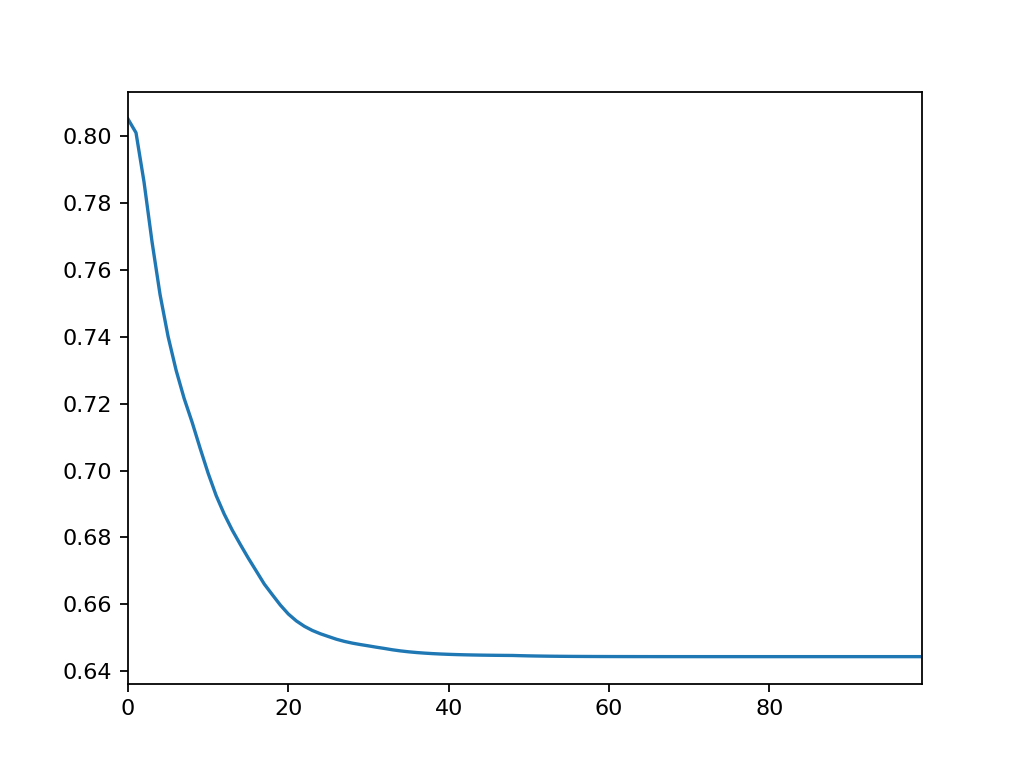

In [117]:
%matplotlib notebook
pd.Series([a._value for a in losses]).astype(onp.float).plot()

In [60]:
labels = assign_clusters(new_centers, X, 2)
labels

DeviceArray([2, 0, 1, 0, 2, 2, 2, 1, 1, 2, 2, 0, 0, 1, 0, 2, 1, 0, 0, 1,
             0, 2, 2, 2, 1, 2, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 2, 2, 2, 0,
             2, 2, 0, 2, 1, 2, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2, 2, 0, 2, 0,
             1, 0, 1, 1, 0, 0, 0, 0, 2, 2, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1,
             2, 2, 0, 0, 2, 2, 1, 2, 0, 1, 2, 2, 0, 0, 0, 0, 2, 0, 1, 2,
             2, 1, 2, 2, 0, 1, 1, 2, 0, 2, 2, 0, 1, 2, 1, 1, 0, 0, 2, 0,
             2, 1, 1, 2, 1, 1, 0, 0, 2, 0], dtype=int32)

<IPython.core.display.Javascript object>


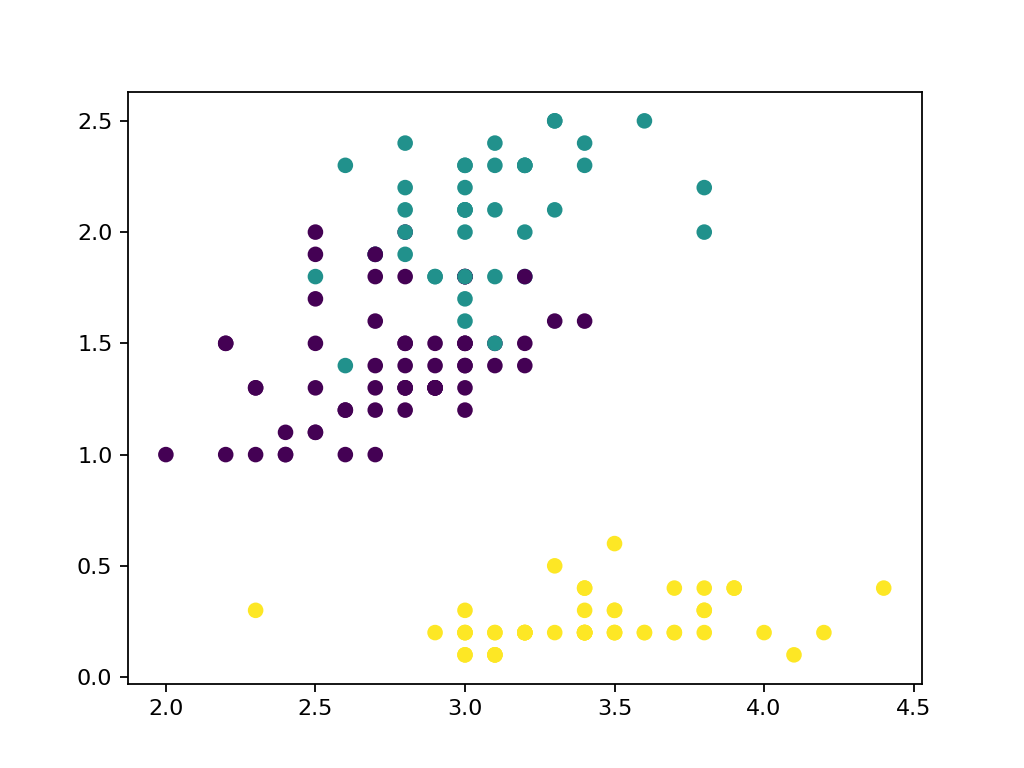

In [61]:
%matplotlib notebook

#fig, ax = plt.subplots()
plt.scatter(x='sepal_width', y='petal_width', c=labels, cmap='viridis', data=iris)